In [171]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from pydantic import BaseModel, Field
import operator

In [172]:
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [173]:
class EvaluationSchema(BaseModel) :
    sentiment :str = Field(description="find the sentiment of the review either positive or negative")

class ReviewReplySchema(BaseModel):
    reply : str = Field(description="a polite and professional reply to the review")
    
class DiagnosisSchema(BaseModel):
    issue_type : Literal["UX", "Bug", "Support", "Perfomance", "Other"] = Field(description="categorise it in an issue type ")
    tone : Literal["angry", "frustated", "sad", "hopeless", "calm"] = Field(description="find the tone of the review")
    urgency :Literal["high", "medium", "low"] = Field(description="Find the urgency level of the review either high, medium or low")

In [174]:
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)
structured_model = model.with_structured_output(EvaluationSchema)
reply_model = model.with_structured_output(ReviewReplySchema)
diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [175]:
class BotState(TypedDict):
    review: str
    sentiment: str
    reply: str
    issue_type : str
    tone : str
    urgency : str

In [176]:
def find_sentiment(state: BotState) :
    review = state["review"]
    prompt = f"""Analyze the sentiment of the following review and respond with either 'positive' or 'negative':
    Review: {review}
    Sentiment:"""  
    state["sentiment"] = structured_model.invoke(prompt).sentiment
    print(state["sentiment"])
    return state         

def check(state: BotState) -> Literal["positive_reply", "run_diagnosis"]:
    sentiment = state["sentiment"]
    if (sentiment == "positive"):
        return "positive_reply"
    else :
        return "run_diagnosis"
    
    
def positive_reply(state: BotState):
    prompt = f"""write a positive reply to the following review:
    Review: {state['review']}"""
    reply = reply_model.invoke(prompt)
    state["reply"] = reply.reply
    return state

def run_diagnosis(state : BotState) :
    prompt = f"""Find the issue type, tone and urgency of the review : {state["review"]} """
    reply = diagnosis_model.invoke(prompt)
    state["issue_type"]  = reply.issue_type
    state["tone"]  = reply.tone
    state["urgency"]  = reply.urgency
    return state

def negative_reply(state: BotState):
    prompt = f"""write a reply to the following review:
    Review: {state['review']}  
    issue_type : {state['issue_type']}
    tone : {state['tone']}
    urgency : {state['urgency']}
    """
    reply = reply_model.invoke(prompt)
    state["reply"] = reply.reply
    return state

In [177]:
graph = StateGraph(BotState)

# add nodes
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_reply", positive_reply)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_reply",negative_reply)

# add edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check)
graph.add_edge("positive_reply", END)
graph.add_edge("run_diagnosis", "negative_reply")
graph.add_edge("negative_reply", END)

# compile graph
workflow = graph.compile()

In [180]:
initial_state ={
    "review": "I think there is an issue with emails." 
    }
final_state = workflow.invoke(initial_state)
print(final_state)

negative
{'review': 'I think there is an issue with emails.', 'sentiment': 'negative', 'reply': 'Thank you for bringing this to our attention. We understand there might be an issue with emails and our team will investigate it. We appreciate your patience.', 'issue_type': 'Bug', 'tone': 'calm', 'urgency': 'low'}


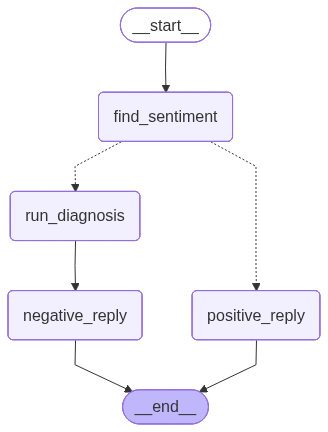

In [179]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())